# SRD Semestr zimowy 2023/24 Zaliczenie ćwiczeń

Wypełniony notebook z numerem indeksu w nazwie pliku proszę wysyłać na lkrain@sgh.waw.pl.

## Import bibliotek

In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier as RFC, GradientBoostingClassifier as GBC
from sklearn.tree import plot_tree, DecisionTreeClassifier as CART
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from scipy import stats
import seaborn as sns

## Zadanie 1 (25pkt)

**(2p)** Załaduj dane z adresu http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric do `DataFrame`. Dane nie mają nagłówka. Użyj adresu URL w wywołaniu funkcji, a nie lokalnego pliku.

In [60]:
DataFrame=pd.read_fwf('http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric', header=None)

**(2p)** Zmień nazwę ostatniej kolumny na `target`. Kolumna informuje o niespłacaniu kredytu przez klienta - 2 => klient nie spłaca kredytu, 1=> klient spłaca kredyt. Przekoduj `target` tak, aby klienci nie spłacający kredytu byli oznaczeni jako 1 i 0 w przeciwnym przypadku.

In [61]:
DataFrame.rename(columns = {24:'target'}, inplace = True)
DataFrame['target'] = np.where(DataFrame['target'] == 2, 1, 0)

**(3p)** Sprawdź liczebności wartości zmiennej `target`. W jaki sposób można rozwiązać problem niezbilansowanych danych? Podaj co najmniej 3 sposoby.

In [62]:
DataFrame['target'].value_counts()

0    700
1    300
Name: target, dtype: int64

Żeby rozwiazać problem niezbilansowanych danych, można wykorzystac kilka metod:
* oversampling - powielanie danych z mniejszych klas, żeby wyrównać proporcje pomiedzy grupami
* undersampling - usuwanie danych z większych klas
* zastosowanie wag klas - nadawanie większej wagi mniej licznego klasie

**(2p)** Podziel dane na zbiór treningowy **(85%)** i walidacyjny **(15%)** z ziarnem losowości **32**. Zmienną celu jest `target`, wszystkie pozostałe zmienne są predyktorami.

In [63]:
X = DataFrame.drop('target', axis=1)
y = DataFrame['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=32)

**(2p)** Wytrenuj regresję logistyczną `sklearn.linear_model.LogisticRegression`. Upewnij się, że model **nie jest** regularyzowany. Ile współczynników różnych od 0 występuje w zbudowanym modelu?

In [64]:
model = LR(penalty=None, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, penalty=None)

In [65]:
model.coef_[0] != 0
#nie ma żadnego współczynnika, który jest równy zero

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [66]:
model.coef_[0].shape
#współczynników różnych od zera jest 24

(24,)

**(2p)** Przeprowadź selekcję zmiennych (zbuduj nowy model `sklearn.linear_model.LogisticRegression`) poprzez ustawienie odpowiedniego typu regularyzacji. Ustaw ziarno losowości na **11** i ustaw parametr odpowiadający za siłę regularyzacji na **0.5**. Ile współczynników modelu jest równych 0? 

In [67]:
model2 = LR(penalty='l1', C=0.5, max_iter=1000, solver='liblinear', random_state=11)
model2.fit(X_train, y_train)

LogisticRegression(C=0.5, max_iter=1000, penalty='l1', random_state=11,
                   solver='liblinear')

In [68]:
model2.coef_[0] !=0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False])

In [69]:
model2.coef_[0].shape
#współczynników różnych od zera jest 20, ponieważ 4 z nich sa równe 0

(24,)

**(2p)** Określ jak regularyzacja **Elastic net** łączy się z regularyzacją **L1** i **L2**.

Regularyzacja Elastic net jest połączeniem regularyzacji L1 i L2. Do funkcji straty modelu są dodawane składniki zarówno L1, jak i L2. Wprowadzane są hiperparametry, żeby kontrolować wpływ obu rodzajów regularyzacji.

Elastic net pozwala na jednoczesne skorzystanie z L1 (indukowanie rzadkości modelu) i L2 (ograniczanie wartości wag)

**(5p)** Używając modelu po selekcji zmiennych policz koszt błędnych predykcji na zbiorze walidacyjnym. Koszt False Positive wynosi **2**, a koszt False Negative wynosi **5**. Użyj progu odcięcia równego **0.4**.

In [76]:
score_val = model2.predict_proba(X_test)[:, 1]
score_train = model2.predict_proba(X_train)[:, 1]

costmat = np.array([[0, 2], [5, 0]])
cost_val = cutoff_analysis(y_test, score_val, cost_matrix=costmat)
cost_train = cutoff_analysis(y_train, score_train, cost_matrix=costmat)
costmat

plt.figure()
plt.xlabel("Cutoff point")
plt.ylabel("Cost per client")
plt.title("Cost vs. cut-off")

plt.plot(np.arange(0, 1.0, 0.01), cost_val)
plt.plot(np.arange(0, 1.0, 0.01), cost_train, color="red")
plt.plot([0, 1], [min(cost_val), min(cost_val)], color = 'gray', label = "Min Cost Val = " + \
         str(round(min(cost_val),3)) + " for k = " + str(round(np.arange(0, 1.0, 0.01)[cost_val.index(min(cost_val))],2)))
plt.plot([0, 1], [min(cost_train), min(cost_train)], color = 'gray', linestyle = ":", label = "Min Cost Train = " + \
         str(round(min(cost_train),3)) + " for k = " + str(np.arange(0, 1.0, 0.01)[cost_train.index(min(cost_train))]))

plt.legend()

NameError: name 'cutoff_analysis' is not defined

**(5p)** Dana jest następująca macierz trafności:

Wartości predykcji są w kolumnach, wartości rzeczywiste w wierszach.

| A\P | 1   | 0   |
|-----|-----|-----|
| 1   | 123 | 321 |
| 0   | 324 | 456 |

Policz:
* Accuracy
* Precision
* Recall
* F1-score

In [71]:
ACC = (123 + 456) / (123+321+324+456)
PREC = (456) / (456 + 324)
REC = (456) / (456 + 321)
F1 = 2 * PREC * REC / (PREC + REC)
print("ACC ", ACC, "\nPREC ", PREC, "\nREC ", REC, "\nF1 ", F1)

ACC  0.4730392156862745 
PREC  0.5846153846153846 
REC  0.5868725868725869 
F1  0.5857418111753372


## Zadanie 2 (25 pkt)

**(1p)** Załaduj dane z adresu https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv do DataFrame. Użyj adresu URL w wywołaniu funkcji, a nie lokalnego pliku.

In [77]:
dataset = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv",
    sep=';',
    header=0)
dataset

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


**(1p)** Sprawdź czy w zbiorze występują braki danych.

In [78]:
dataset.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

**(2p)** Stwórz wykres rozrzutu z przedstawionym oszacowaniem regresji liniowej. Użyj zmiennych:
* oś y - `alcohol`
* oś x - `residual sugar`

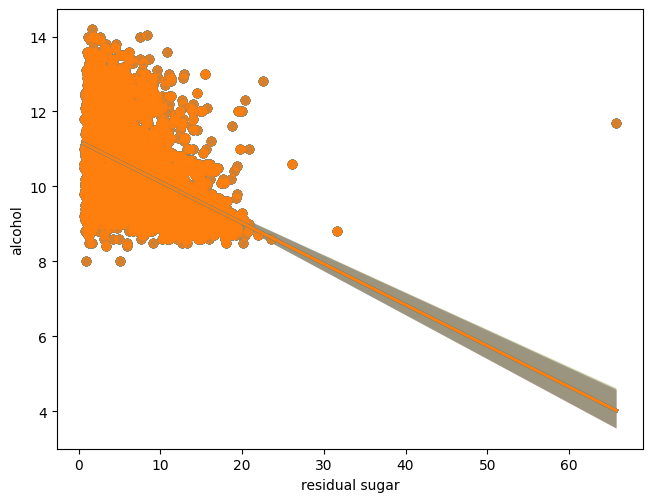

In [79]:
f, axes = plt.subplots()
plt.tight_layout(pad=0.4, w_pad=1.0, h_pad=1.0)
for n, col in enumerate(dataset):
    sns.regplot(x='residual sugar', y="alcohol", data=dataset)

**(3p)** Wykres wskazuje na występowanie obserwacji odstających. Usuń obserwacje odstające za pomocą metody z-score. Policz z-score dla wszystkich kolumn w zbiorze i usuń obserwacje, gdzie dowolna zmienna przyjmuje wartość większą niż **4** odchylenia standardowe od średniej. Wygeneruj ponownie wykres z poprzedniego punktu, aby potwierdzić usunięcie obserwacji odstających.

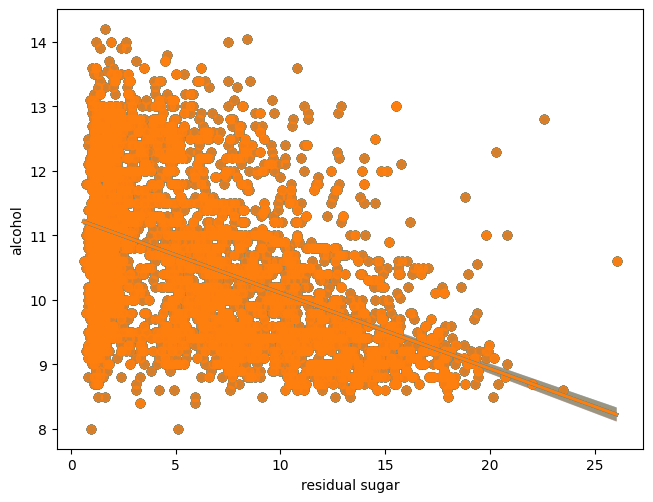

In [80]:
stats.zscore(dataset)
dataset = dataset[(np.abs(stats.zscore(dataset)) < 4).all(axis=1)]

f, axes = plt.subplots()
plt.tight_layout(pad=0.4, w_pad=1.0, h_pad=1.0)
for n, col in enumerate(dataset):
    sns.regplot(x='residual sugar', y="alcohol", data=dataset)

**(1p)** Przekoduj zmienną `quality`. Dobre wina (quality większe bądź równe **6**) niech będą oznaczone wartością 1, a słabe wina (quality mniejsze niż 6) wartością 0. Nadpisz kolumnę `quality`.

In [50]:
dataset['quality'] = (dataset['quality'] >= 6).astype(int)

**(1p)** Podziel dane na zbiór treningowy **(85%)** i walidacyjny **(15%)** z ziarnem losowości **42**. Zmienną celu jest `quality`, wszystkie pozostałe zmienne są predyktorami.

In [51]:
X = dataset.drop('quality', axis=1)
y = dataset['quality']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

**(1p)** Zbuduj model `sklearn.tree.DecisionTreeClassifier` z parametrem `random_state` równym **42** i parametrem kosztu równym **0**.

**(3p)** W jaki sposób i dlaczego przeprowadza się **przycinanie** drzewa CART?


Przycinanie drzewa CART redukuje jego złożoność poprzez usuwanie mniej istotnych gałęzi, co poprawia zdolność generalizacji modelu i zapobiega przeuczeniu.

**(4p)** Wytrenuj model `sklearn.ensemble.RandomForestClassifier`. Zoptymalizuj hiperparametr `max_samples` (sprawdź wartości 0.1, 0.2, ..., 1.0) - użyj F1-score jako metryki decyzyjnej. Dla każdego stworzonego modelu użyj ziarna losowości **10**. Pozostałe parametry modelu pozostaw na wartościach domyślnych. 

**(2p)** Które 2 zmienne są najbardziej istotne na podstawie **feature importance** optymalnego lasu? Podaj ich nazwy.

**(4p)** Wytrenuj model `sklearn.ensemble.GradientBoostingClassifier`. Zoptymalizuj hiperparametr określający liczbę iteracji uczenia (sprawdź wartości od 50 do 300 co 50) - użyj F1-score jako metryki decyzyjnej. Dla każdego stworzonego modelu użyj ziarna losowości **10** oraz ustaw, aby każde drzewo wykorzystywało **50%** losowo wybranych obserwacji ze zbioru uczącego. Pozostałe parametry modelu pozostaw na wartościach domyślnych.

**(2p)** Porównaj jakość 3 stworzonych modeli (CART, optymalny Random Forest, optymalny Gradient Boosted Trees) poprzez pomiar F1-score (na zbiorze walidacyjnym) i przedstaw błędy na wykresie słupkowym. Który model jest najlepszy pod kątem F1-score?